# Assignment 3

## About

Make sure to put all the contents from the zip file into the same directory as this notebook.

You are free the use the boilerplate code if you wish, but you do not have to. 

## Imports

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import QasmSimulator
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.circuit import Parameter, ParameterVector
import numpy as np
from copy import deepcopy

## Reuse some code from Assignment 2

In [2]:
# Z-basis states
ket0 = np.array([[1], [0]], dtype=np.complex128)
ket1 = np.array([[0], [1]], dtype=np.complex128)

# X-gate
X = ket0 @ ket1.conj().T + ket1 @ ket0.conj().T

# Identity
I = np.eye(2)

# Complex
i = 1j


# Create controlled U gate
def create_CU_gate(U):
    return np.kron(ket0 @ ket0.conj().T, np.eye(2)) + np.kron(ket1 @ ket1.conj().T, U)


# CX-gate
CX = create_CU_gate(X)

# Get backend
backend = QasmSimulator()


#Get statevector from circuit
def get_state_vector(qc: QuantumCircuit):
    return Statevector(qc)

## Excercises

### Pen/Paper
### 1

Describe the following circuits as operators on the form $ U = (...\otimes...) \circ (...\otimes...) \circ ... $.

<b>a)</b> In $ \mathcal{H}^{\otimes 3} $

![title](Circuit1.png)

<b>b)</b> In $ \mathcal{H}^{\otimes 4} $

![title](Circuit2.png)

a) $U = (H\otimes I \otimes T) \circ (CX \otimes I) \circ (I \otimes CX)$

b) $U = (H\otimes I \otimes S \otimes I) \circ (I\otimes CCX) \circ (Tdg \otimes I \otimes I\otimes I)$

### Programming
### 2 

*Parameter* and *ParameterVector* from *qiskit.circuit* can be helful when building parametrized circuits.

Implement the following operator as a circuit in Qiskit with four qubits in the initial state $|0000\rangle$:

$ U =  (Rx(θ_1) \otimes Ry(θ_2) \otimes Rz(λ_1) \otimes U3(θ, ϕ, λ)) \circ (I \otimes I \otimes CX) \circ (I \otimes CX \otimes I) \circ (CX \otimes I \otimes I) \circ (H \otimes I \otimes I \otimes I)  $

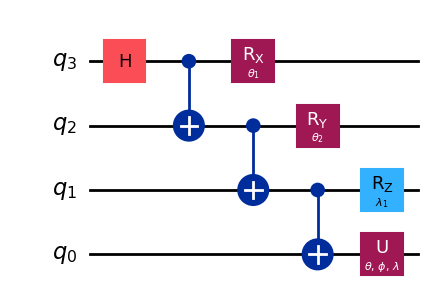

In [3]:
qc = QuantumCircuit(4)

qc.h(3)
qc.cx(3,2)
qc.cx(2,1)
qc.cx(1,0)
qc.u(Parameter("$\\theta$"), Parameter("$\phi$"), Parameter("$\lambda$"),0)
qc.rz(Parameter("$\lambda_1$"), 1)
qc.ry(Parameter("$\\theta_2$"), 2)
qc.rx(Parameter("$\\theta_1$"), 3)


qc.draw("mpl", reverse_bits=True)

### 3

<b>a)</b> Create a function *U3(θ, ϕ, λ)* that returns the *U3-gate matrix* for the specified parameters


In [4]:
# a)
def U3(θ, φ, λ) -> np.ndarray:
    sin = np.sin(θ/2)
    cos = np.cos(θ/2)
    matrix = np.array([
        [cos, -np.exp(i*λ)*sin],
        [np.exp(i*φ)*sin, np.exp(i*(φ+λ))*cos]
    ], dtype="complex")
    return matrix


<b>b)</b> Express $ I, X, Y , Z, $ and $H$ as U3-gates. Test with your function from <b>a)</b>

In [5]:
# I
array_to_latex(U3(0,0,0))

<IPython.core.display.Latex object>

In [6]:
# X
array_to_latex(U3(np.pi,0,np.pi))

<IPython.core.display.Latex object>

In [7]:
# Y
array_to_latex(U3(np.pi,np.pi/2,np.pi/2))

<IPython.core.display.Latex object>

In [8]:
# Z
array_to_latex(U3(0,0,np.pi))

<IPython.core.display.Latex object>

In [9]:
# Hadamard
array_to_latex(U3(np.pi/2,0,np.pi))

<IPython.core.display.Latex object>

<b>c)</b> The composition of two U3 gates is equivalent to another U3 gate. Create a function *U3_decompose(A: np.ndarray)* which takes in a U3 gate and calculates the angles $\theta, \phi$ and $\lambda$, as well as the global phase $\alpha$. Verify that you've successfully identified the correct values by comparing the results.

In [10]:
def U3_decompose(A: np.ndarray):
    # make a deepcopy so we dont accidentally alter the original matrix
    A = deepcopy(A)

    θ = 2*np.arccos(np.absolute(A[0,0]))
    phase_val = A[0,0]/np.cos(θ/2)
    α = np.angle(A[0,0]/np.cos(θ/2))
    λ = np.angle(-1*A[0,1]/phase_val)
    φ = np.angle(A[1,0]/phase_val)

    print(α, θ, φ, λ)
    return α, θ, φ, λ

A = U3(1, 2, 3) @ U3(4, 5, 6)
display(array_to_latex(A, precision=3))

α, θ, φ, λ = U3_decompose(A)
B = np.exp(i * α) * U3(θ, φ, λ)

# Should display the same as A
display(array_to_latex(B, precision=3))

<IPython.core.display.Latex object>

-2.181309069553885 2.0328904262388434 -0.1507685581321429 1.6638307757011535


<IPython.core.display.Latex object>

### 4

<b>a)</b> Create a function *measure(qc: QuantumCircuit)* that measures all qubits of a circuit and returns *result.get_counts()*. Test it using a circuit implementing $|Φ^+⟩$.

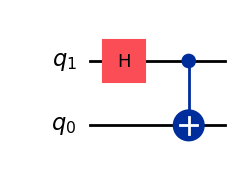

In [11]:
def measure(qc: QuantumCircuit, n_shots=1000):
    # result = transpile(qc, backend)
    # result.measure_all()
    qc.measure_all()
    qc_transpiled = transpile(qc, backend)
    result = backend.run(qc_transpiled, shots=n_shots).result().get_counts()
    return result

qc = QuantumCircuit(2)
qc.h(1)
qc.cx(1,0)
qc.draw("mpl", reverse_bits=True)

<b>b)</b> Plot the result as a histogram (You can use *plot_histogram* from *qiskit.visualization*)

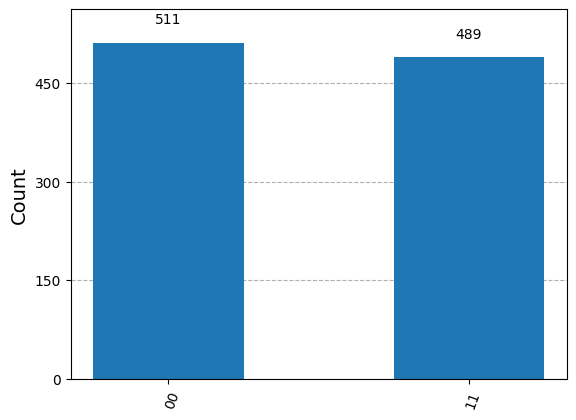

In [12]:
plot_histogram(measure(qc))

<b>c)</b> Modify your measure function such that you can select the number of shots.

### 5

Consider a unitary $ U = (Ry(θ) \otimes I) \circ CX  $ in $ \mathcal{H}^{\otimes 2} $, with $ θ = \pi / 4 $

<b>a)</b> Calculate $|\psi \rangle = U|01\rangle $ . You can choose whether you wish to do this on paper or with code.


In [13]:
def U_gate(theta=np.pi/4):
    sin = np.sin(theta/2)
    cos = np.cos(theta/2)
    return np.kron(np.array([[cos, -sin],[sin, cos]]), np.eye(2)) @ np.kron(np.eye(2), np.array([[0,1],[1,0]]))

psi = U_gate()@np.kron(ket0, ket1)
array_to_latex(psi)

<IPython.core.display.Latex object>

<b>b)</b> Compute the measurement probabilities for a standard measurement of $|\psi \rangle $


In [14]:
print(get_state_vector(psi).probabilities())
prob = psi.conj().T @ np.diag([1,2,3,4]) @ psi
prob
array_to_latex(prob)

[0.85355339 0.         0.14644661 0.        ]


<IPython.core.display.Latex object>

<b>c)</b> Create $|\psi \rangle $ as a circuit in Qiskit.

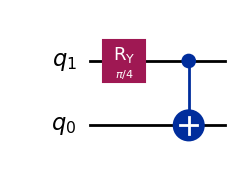

In [15]:
qc = QuantumCircuit(2)

qc.ry(np.pi/4, 1)
qc.cx(1,0)

qc.draw("mpl", reverse_bits=True)

<b>d)</b> Measure your circuit. Compare your results to <b>b)</b>

In [16]:
measure(qc)

{'00': 846, '11': 154}